Data wrangling  of proteomics data - fetch peptide counts and Accession names

In [1]:
# Import packages needed for the notebook
import math
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib_venn import venn2, venn3, venn2_circles, venn3_circles

In [2]:
# Read the Excel file into a pandas DataFrame (df)
df_proteomics = pd.read_excel('../Data/03_Proteomics_data/20221124_FJ_E1200_MWN_15cm_140min_500ng_#1572_proteins.xlsx')
df_proteomics

,Checked,Protein FDR Confidence: Combined,Master,Accession,Description,Exp. q-value: Combined,Sum PEP Score,Coverage [%],# Peptides,# PSMs,...,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101
0,False,High,Master Protein,AO090003000935-T-p1,transcript=AO090003000935-T | gene=AO090003000...,0.000,599.687,89,31,7127,...,NaN,Minimal medium,NaN,NaN,NaN,NaN,Minimal medium,NaN,NaN,NaN
1,False,High,Master Protein,AO090023000944-T-p1,transcript=AO090023000944-T | gene=AO090023000...,0.000,523.784,68,32,3237,...,NaN,NaN,Sample 1,50.510606,3.145030,NaN,NaN,Sample 1,4.740753e+07,3.436191e+07
2,False,High,Master Protein,AO090003001591-T-p1,transcript=AO090003001591-T | gene=AO090003001...,0.000,519.742,68,33,2987,...,NaN,NaN,Sample 2,48.832877,2.987014,NaN,NaN,Sample 2,4.286160e+07,2.895349e+07
3,False,High,Master Protein,RFP_Fusion,RFP_Fusion,0.000,450.464,64,35,398,...,NaN,NaN,Sample 3,40.962363,3.101377,NaN,NaN,Sample 3,4.792621e+07,3.645038e+07
4,False,High,Master Protein,AO090005001300-T-p1,transcript=AO090005001300-T | gene=AO090005001...,0.000,384.472,90,45,554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,False,Medium,Master Protein,AO090001000075-T-p1,transcript=AO090001000075-T | gene=AO090001000...,0.044,1.795,4,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,False,Medium,Master Protein,AO090005001355-T-p1,transcript=AO090005001355-T | gene=AO090005001...,0.046,1.790,14,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
863,False,Medium,Master Protein,AO090003000247-T-p1,transcript=AO090003000247-T | gene=AO090003000...,0.047,1.779,4,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
864,False,Medium,Master Protein,AO090001000680-T-p1,transcript=AO090001000680-T | gene=AO090001000...,0.048,1.774,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Media specific statistical analysis

Carry out statistical analysis - calculate mean of all abundances (all_ab) per medium type. Make a statistical comparison of different media compositions by caluclating mean abundances for the scaled and raw abundances data. Borth scaled and raw abundace samples carry the same name:
- Sample: 1 (F16), 2 (F17), and 3 (F18)   = Minimum media (mM)
- Sample 13 (F28), 14 (F29), and 15 (F30) = Minimum meadia with more Nitrogen (mMN) 

In order to make correct seelction, we will create a boolean mask which will allow us to select dataframe variables according to specific characters they contain in the dataframe such as using 'Scaled' to select scaled abundances and 'Abundance' to select raw abundances


In [3]:
# Create a boolean mask that is True for columns that contain "Scaled" and "F16", "F17", or "F18"
mM_s_mask = df_proteomics.columns.str.contains('Scaled', 'Abundance') & df_proteomics.columns.str.contains('F16|F17|F18', regex=True)
mMN_s_mask = df_proteomics.columns.str.contains('Scaled', 'Abundance') & df_proteomics.columns.str.contains('F28|F29|F30', regex=True)

# Create a boolean mask that is True for columns that contain "Abundance" and "F16", "F17", or "F18"
mM_r_mask = df_proteomics.columns.str.contains('Abundance:') & df_proteomics.columns.str.contains('F16|F17|F18', regex=True)
mMN_r_mask = df_proteomics.columns.str.contains('Abundance:') & df_proteomics.columns.str.contains('F28|F29|F30', regex=True)

# Use the mask to select the columns you are interested
mM_s = df_proteomics.loc[:,mM_s_mask]
mMN_s = df_proteomics.loc[:,mMN_s_mask]
mM_r = df_proteomics.loc[:,mM_r_mask]
mMN_r = df_proteomics.loc[:,mMN_r_mask]
mM_r

,"Abundance: F16: Sample, 1","Abundance: F17: Sample, 2","Abundance: F18: Sample, 3"
0,9.597858e+07,9.416572e+07,1.297344e+08
1,2.378266e+08,3.016177e+08,2.504219e+08
2,9.888853e+09,1.123887e+10,1.030518e+10
3,6.556024e+05,8.538809e+05,5.388381e+05
4,7.204276e+07,3.532077e+07,1.257048e+07
...,...,...,...
861,1.819305e+05,2.070978e+04,NaN
862,2.104682e+04,5.864526e+04,NaN
863,NaN,NaN,NaN
864,NaN,NaN,NaN


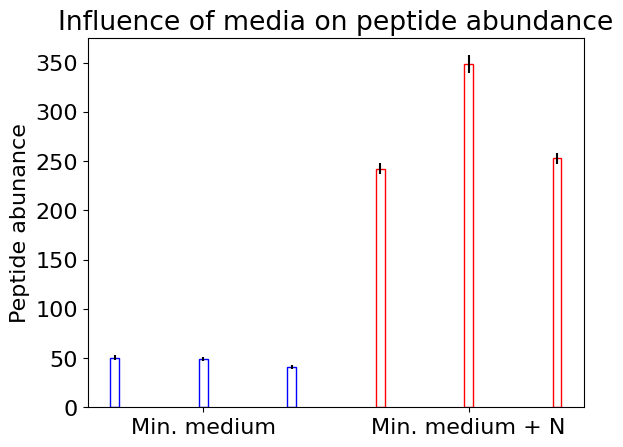

In [44]:
# Set width of each bar
bar_width = 0.1

# Plot the first set of bars
plt.bar(mM_s.columns, mM_s.mean(), bar_width, yerr=mM_s.std()/np.sqrt(mM_s.shape[0]), color='none', edgecolor='blue', label='mM_s_mask')

# Increment x-coordinates for the next set of bars
x_coords = np.arange(len(mM_s_mask)) + bar_width

# Plot the second set of bars
plt.bar(mMN_s.columns, mMN_s.mean(), bar_width, yerr=mMN_s.std()/np.sqrt(mMN_s.shape[0]), color='none', edgecolor='red', label='mMN_s_mask')

# Set x-axis ticks
x_ticks = ['Min. medium', 'Min. medium + N']
plt.xticks([1, 4], x_ticks)

# Set axis labels and title
plt.ylabel('Peptide abunance')
plt.title('Influence of media on peptide abundance')

# Show plot
plt.show()

### Mean of Abundances for Scaled and Raw data 

In [5]:
# Calculate mean abundances per Accession by using the abundances variable
df_proteomics['mM mean abundances (Scaled)'] = mM_s.mean(axis=1)
df_proteomics['mMN mean abundances (Scaled)'] = mMN_s.mean(axis=1)
df_proteomics['mM mean abundances (Raw)'] = mM_r.mean(axis=1)
df_proteomics['mMN mean abundances (Raw)'] = mMN_r.mean(axis=1)

In [6]:
# Print mean of scaled (s) abundances per Accession
df_abundance_means = df_proteomics.loc[:, ['Accession', 'mM mean abundances (Scaled)', 'mMN mean abundances (Scaled)', 'mM mean abundances (Raw)', 'mMN mean abundances (Raw)']] 
df_abundance_means

,Accession,mM mean abundances (Scaled),mMN mean abundances (Scaled),mM mean abundances (Raw),mMN mean abundances (Raw)
0,AO090003000935-T-p1,5.700000,64.833333,1.066262e+08,1.494872e+09
1,AO090023000944-T-p1,250.433333,53.733333,2.632887e+08,7.327970e+07
2,AO090003001591-T-p1,230.066667,69.166667,1.047763e+10,4.066686e+09
3,RFP_Fusion,0.466667,496.733333,6.827738e+05,8.809622e+08
4,AO090005001300-T-p1,50.566667,94.433333,3.997800e+07,9.707511e+07
...,...,...,...,...,...
861,AO090001000075-T-p1,110.200000,310.600000,1.013201e+05,3.909362e+05
862,AO090005001355-T-p1,105.400000,184.200000,3.984604e+04,9.575187e+04
863,AO090003000247-T-p1,NaN,NaN,NaN,NaN
864,AO090001000680-T-p1,NaN,389.333333,NaN,9.818556e+04


### Normalization of Abundances for Scaled and Raw data 

In [7]:
# Apply Min-Max normalization 
mM_s_norm = (mM_s- mM_s.min()) / (mM_s.max() - mM_s.min())
mMN_s_norm = (mMN_s - mMN_s.min()) / (mMN_s.max() - mMN_s.min())
mM_r_norm = (mM_r - mM_r.min()) / (mM_r.max() - mM_r.min())
mMN_r_norm = (mMN_r - mMN_r.min()) / (mMN_r.max() - mMN_r.min())

#============ Alternative =============#
# Create a scalar object
#scaler = MinMaxScaler()

# Normalize the scaled abundance values
#mm_norm = scaler.fit_transform(mm)
#rm_norm = scaler.fit_transform(rm)
#======================================#

### Mean of Normalized Abundances

In [8]:
# Calculate mean of scaled + normalized abundances per Accession
df_proteomics['mM mean abundances (Scaled-Normalized)'] = mM_s_norm.mean(axis=1)
df_proteomics['mMN mean abundances (Scaled-Normalized)'] = mMN_s_norm.mean(axis=1)
df_proteomics['mM mean abundances (Raw-Normalized)'] = mM_r_norm.mean(axis=1)
df_proteomics['mMN mean abundances (Raw-Normalized)'] = mMN_r_norm.mean(axis=1)

#======================================================= ALTERNATIVE ================================================================#
# Create a scalar object
#scaler = MinMaxScaler() 
#df_proteomics[
#    ['mM mean abundances (Scaled)','mMN mean abundances (Scaled)', 'mM mean abundances (Raw)','mMN mean abundances (Raw)']] = scaler.fit_transform(df[
#        ['mM mean abundances (Scaled)','mMN mean abundances (Scaled)', 'mM mean abundances (Raw)','mMN mean abundances (Raw)']
#        ])
        
#df_norm = df_proteomics.rename(
#    columns = {
#        'mM mean abundances (Scaled)':'mM mean abundances (S-Normalized)',
#        'mMN mean abundances (Scaled)':'mMN mean abundances (S-Normalized)',
#        'mM mean abundances (Raw)':'mM mean abundances (R-Normalized)',
#        'mMN mean abundances (Raw)':'mMN mean abundances (R-Normalized)'}
#        )
#====================================================================================================================================#

# Print dataframe of normalized mean abundances per Accession
df_abundance_means_normalized = df_proteomics.loc[:, ['Accession', 'mM mean abundances (Scaled-Normalized)', 'mMN mean abundances (Scaled-Normalized)', 'mM mean abundances (Raw-Normalized)', 'mMN mean abundances (Raw-Normalized)']]
df_abundance_means_normalized 

,Accession,mM mean abundances (Scaled-Normalized),mMN mean abundances (Scaled-Normalized),mM mean abundances (Raw-Normalized),mMN mean abundances (Raw-Normalized)
0,AO090003000935-T-p1,0.007994,0.059285,0.010224,0.417923
1,AO090023000944-T-p1,0.356292,0.044270,0.025062,0.017628
2,AO090003001591-T-p1,0.329555,0.058537,1.000000,1.000000
3,RFP_Fusion,0.000482,0.426804,0.000064,0.225240
4,AO090005001300-T-p1,0.079428,0.080759,0.003882,0.024045
...,...,...,...,...,...
861,AO090001000075-T-p1,0.190296,0.254802,0.000010,0.000090
862,AO090005001355-T-p1,0.142082,0.122683,0.000003,0.000015
863,AO090003000247-T-p1,NaN,NaN,NaN,NaN
864,AO090001000680-T-p1,NaN,0.309596,NaN,0.000019


Print a summary dataframe of Scaled and Raw mean abundances per Accession

In [9]:
# Merge the dataframes (df_proteomics and df_singalpp)
# The resulting dataframe(df_merged_prosig) contains only the variables matching among the two dataframes
df_merged_abundance_means = pd.merge(df_abundance_means, df_abundance_means_normalized, on='Accession')

# Select and print the desired parameters
df_merged_abundance_means = df_merged_abundance_means[['Accession', 
'mM mean abundances (Scaled)', 'mM mean abundances (Scaled-Normalized)', 
'mMN mean abundances (Scaled)', 'mMN mean abundances (Scaled-Normalized)', 
'mM mean abundances (Raw)', 'mM mean abundances (Raw-Normalized)',
'mMN mean abundances (Raw)', 'mMN mean abundances (Raw-Normalized)']]

df_merged_abundance_means

,Accession,mM mean abundances (Scaled),mM mean abundances (Scaled-Normalized),mMN mean abundances (Scaled),mMN mean abundances (Scaled-Normalized),mM mean abundances (Raw),mM mean abundances (Raw-Normalized),mMN mean abundances (Raw),mMN mean abundances (Raw-Normalized)
0,AO090003000935-T-p1,5.700000,0.007994,64.833333,0.059285,1.066262e+08,0.010224,1.494872e+09,0.417923
1,AO090023000944-T-p1,250.433333,0.356292,53.733333,0.044270,2.632887e+08,0.025062,7.327970e+07,0.017628
2,AO090003001591-T-p1,230.066667,0.329555,69.166667,0.058537,1.047763e+10,1.000000,4.066686e+09,1.000000
3,RFP_Fusion,0.466667,0.000482,496.733333,0.426804,6.827738e+05,0.000064,8.809622e+08,0.225240
4,AO090005001300-T-p1,50.566667,0.079428,94.433333,0.080759,3.997800e+07,0.003882,9.707511e+07,0.024045
...,...,...,...,...,...,...,...,...,...
861,AO090001000075-T-p1,110.200000,0.190296,310.600000,0.254802,1.013201e+05,0.000010,3.909362e+05,0.000090
862,AO090005001355-T-p1,105.400000,0.142082,184.200000,0.122683,3.984604e+04,0.000003,9.575187e+04,0.000015
863,AO090003000247-T-p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
864,AO090001000680-T-p1,NaN,NaN,389.333333,0.309596,NaN,NaN,9.818556e+04,0.000019


In [10]:
# Convert and save a summary dataframe (.csv or .xlsx)
df_merged_abundance_means.to_excel('../Data/04_Data_wrangling/abundance_means_merged.xlsx', index=False)

# SignalP predicted signal peptides

In [11]:
# Read the Excel file into a pandas dataframe (df_singalp)
df_signalP = pd.read_excel('../Data/01_SignalP_output/sigpep_predictt.xlsx')
df_signalP

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
0,AO090005000016-T-p1,0,23,0.999803,MAPSHSFMLFLSVICTHLCSLVV
1,AO090005000029-T-p1,0,23,0.999835,MHLRNIVIALAATAVASPVDLQD
2,AO090005000042-T-p1,0,23,0.999843,MKASFISRLLSLTAFAISSNLSY
3,AO090005000053-T-p1,0,41,0.854809,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL
4,AO090005000059-T-p1,0,18,0.999821,MHLQATLAVGLSLLGLTL
...,...,...,...,...,...
1056,AO090103000483-T-p1,0,19,0.833106,MKTSFLLAAIGFLYRLPCS
1057,AO090103000487-T-p1,0,19,0.999710,MTRYLSFLFLLILFGNSVF
1058,AO090103000493-T-p1,0,17,0.999791,MRGIVALSFLSVALGVT
1059,AO090701000994-T-p1,0,18,0.999845,MRLLLIAPLFSAVSYGAQ


Cross-reference with predicted signal peptides in notebook 00 and make a dataframe containing the parameters:
- Accession
- Peptide count
- Signal peptide likelyhood
- Mean abundances scaled and normalized
- Peptide sequence

In [12]:
# Reset the index of the dataframe (df_signalp) and save as processed dataframe (df_signalpp)
df_signalPP = df_signalP.reset_index()
# Change the name of the "gene" in the df_signalp dataframe into "Accession" in the df_signalpp
# This will allow us to merge the df_proteomics and df_singalpp on a specific parameter such as "Accession"
df_signalPP = df_signalP.rename(columns={'gene': 'Accession', 'sequence': 'Peptide sequences', 'signal_peptide_likelyhood': 'Propability for correct peptide identification'})
# 'Propability for correct peptide identification' --> Shows the likelihood of having the sequence being cut at final amino acid location shown on the 'Peptide sequences'

# Merge the dataframes (df_proteomics and df_singalpp)
# The resulting dataframe(df_merged_prosig) contains only the variables matching among the two dataframes
df_merged_proteomics_signalP = pd.merge(df_merged_abundance_means, df_signalPP, on='Accession')

# Select and print the desired parameters
df_merged_proteomics_signalPP = df_merged_proteomics_signalP[['Accession',  
'mM mean abundances (Scaled)', 'mM mean abundances (Scaled-Normalized)', 
'mMN mean abundances (Scaled)', 'mMN mean abundances (Scaled-Normalized)', 
'mM mean abundances (Raw)', 'mM mean abundances (Raw-Normalized)',
'mMN mean abundances (Raw)', 'mMN mean abundances (Raw-Normalized)', 
'Peptide sequences', 'Propability for correct peptide identification']]
df_merged_proteomics_signalPP

,Accession,mM mean abundances (Scaled),mM mean abundances (Scaled-Normalized),mMN mean abundances (Scaled),mMN mean abundances (Scaled-Normalized),mM mean abundances (Raw),mM mean abundances (Raw-Normalized),mMN mean abundances (Raw),mMN mean abundances (Raw-Normalized),Peptide sequences,Propability for correct peptide identification
0,AO090003000935-T-p1,5.700000,0.007994,64.833333,0.059285,1.066262e+08,0.010224,1.494872e+09,0.417923,MEAFNLHNFLSSLYILLPFVILANPVH,0.999834
1,AO090023000944-T-p1,250.433333,0.356292,53.733333,0.044270,2.632887e+08,0.025062,7.327970e+07,0.017628,MMVAWWSLFLYGLQVAAPAL,0.999845
2,AO090003001591-T-p1,230.066667,0.329555,69.166667,0.058537,1.047763e+10,1.000000,4.066686e+09,1.000000,MMVAWWSLFLYGLQVAAPAL,0.999866
3,AO090010000746-T-p1,105.633333,0.149639,264.400000,0.228295,2.719032e+08,0.025872,8.634503e+08,0.218331,MVSFSSCLRALALGSSVLAVQPVL,0.999747
4,AO090026000003-T-p1,0.833333,0.001087,470.100000,0.414383,1.498718e+06,0.000144,1.061096e+09,0.276919,MAVRIARFLGLSTVAYLALANGID,0.848574
...,...,...,...,...,...,...,...,...,...,...,...
251,AO090020000279-T-p1,NaN,NaN,105.500000,0.092233,NaN,NaN,1.733149e+05,0.000044,MKVQHLSSPFLLFLLPAIAT,0.999775
252,AO090011000174-T-p1,NaN,NaN,364.966667,0.310975,NaN,NaN,2.159021e+05,0.000049,MQLLPVALLLGALAAPTA,0.999818
253,AO090023000365-T-p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRDFLSLLGLASIIASSS,0.999822
254,AO090010000562-T-p1,80.633333,0.115743,57.833333,0.045944,5.244993e+04,0.000005,4.827228e+04,0.000009,MILGLIASLGQAAVAA,0.999807


# Data visualization

### Peptide count per Accesion by different analysis methods

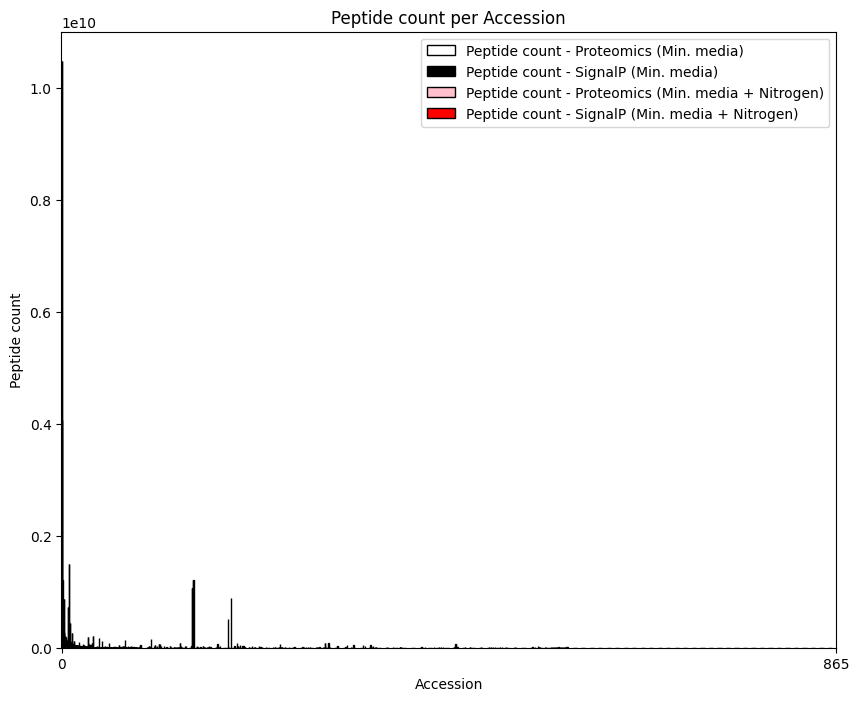

In [13]:
# Define the dataframes and extract the "Accession" and "# Peptides" columns
df_peptide_count_proteomics = df_merged_abundance_means[['Accession', 'mM mean abundances (Raw)', 'mMN mean abundances (Raw)']] 
df_peptide_count_signalP = df_merged_proteomics_signalPP[['Accession', 'mM mean abundances (Raw)', 'mMN mean abundances (Raw)']]

# Rename the "# Peptides" column to indicate which excel file it comes from
df_peptide_count_proteomics = df_peptide_count_proteomics.rename(columns={'mM mean abundances (Raw)': 'Peptide count - Proteomics (Min. media)', 'mMN mean abundances (Raw)': 'Peptide count - Proteomics (Min. media + Nitrogen)'})
df_peptide_count_signalP = df_peptide_count_signalP.rename(columns={'mM mean abundances (Raw)': 'Peptide count - SignalP (Min. media)', 'mMN mean abundances (Raw)': 'Peptide count - SignalP (Min. media + Nitrogen)'})

# Merge the dataframes on the "Accession" column
df_peptide_count_merged_all = pd.merge(df_peptide_count_proteomics, df_peptide_count_signalP, on='Accession', how='outer')

# Fill any NaN values with 0
df_peptide_count_merged_all = df_peptide_count_merged_all.fillna(0)

# Sort the dataframe by "# Peptides" in descending order
all_bars = ['Peptide count - Proteomics (Min. media)', 'Peptide count - SignalP (Min. media)', 'Peptide count - Proteomics (Min. media + Nitrogen)', 'Peptide count - SignalP (Min. media + Nitrogen)']
df_peptide_count_merged_all = df_peptide_count_merged_all.sort_values(by=all_bars, ascending=False)

# Generate the bar plot
df_peptide_count_merged_all.plot(x='Accession', y=all_bars, kind='bar', title='Peptide count per Accession', color=['none', 'black', 'pink', 'red'], edgecolor='black')

ax = plt.gca()
ax.set_xticks([0, df_peptide_count_merged_all.index.get_loc(df_peptide_count_merged_all.index[-1])])
ax.set_xticklabels([0, df_peptide_count_merged_all.index.get_loc(df_peptide_count_merged_all.index[-1])], rotation=0)
ax.figure.set_size_inches(10, 8)

plt.xlabel('Accession')
plt.ylabel('Peptide count')
plt.show()

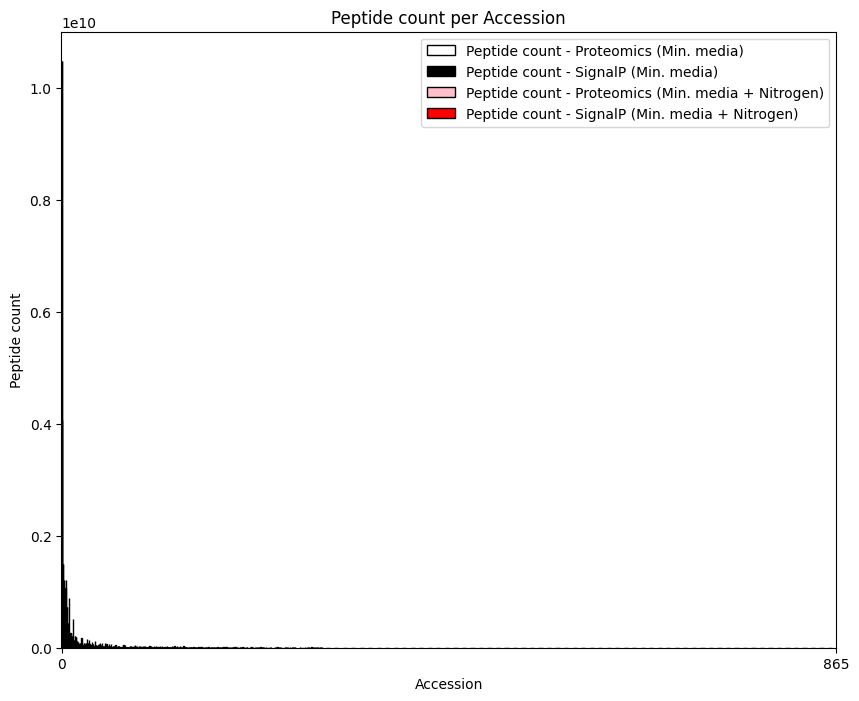

In [14]:
# Define the dataframes and extract the "Accession" and "# Peptides" columns
df_peptide_count_proteomics = df_merged_abundance_means[['Accession', 'mM mean abundances (Raw)', 'mMN mean abundances (Raw)']] 
df_peptide_count_signalP = df_merged_proteomics_signalPP[['Accession', 'mM mean abundances (Raw)', 'mMN mean abundances (Raw)']]

# Rename the "# Peptides" column to indicate which excel file it comes from
df_peptide_count_proteomics = df_peptide_count_proteomics.rename(columns={'mM mean abundances (Raw)': 'Peptide count - Proteomics (Min. media)', 'mMN mean abundances (Raw)': 'Peptide count - Proteomics (Min. media + Nitrogen)'})
df_peptide_count_signalP = df_peptide_count_signalP.rename(columns={'mM mean abundances (Raw)': 'Peptide count - SignalP (Min. media)', 'mMN mean abundances (Raw)': 'Peptide count - SignalP (Min. media + Nitrogen)'})

# Merge the dataframes on the "Accession" column
df_peptide_count_merged_all = pd.merge(df_peptide_count_proteomics, df_peptide_count_signalP, on='Accession', how='outer')

# Fill any NaN values with 0
df_peptide_count_merged_all = df_peptide_count_merged_all.fillna(0)

# Sort the dataframe by "# Peptides" in descending order
df_peptide_count_merged_all['Total_abundance'] = df_peptide_count_merged_all[all_bars].sum(axis=1)
df_peptide_count_merged_total = df_peptide_count_merged_all.sort_values(by=['Total_abundance'], ascending=False)

# Generate the bar plot
all_bars = ['Peptide count - Proteomics (Min. media)', 'Peptide count - SignalP (Min. media)', 'Peptide count - Proteomics (Min. media + Nitrogen)', 'Peptide count - SignalP (Min. media + Nitrogen)']
df_peptide_count_merged_total.plot(x='Accession', y=all_bars, kind='bar', title='Peptide count per Accession', color=['none', 'black', 'pink', 'red'], edgecolor='black')

ax = plt.gca()
ax.set_xticks([0, df_peptide_count_merged_total.index.get_loc(df_peptide_count_merged_total.index[-1])])
ax.set_xticklabels([0, df_peptide_count_merged_total.index.get_loc(df_peptide_count_merged_total.index[-1])], rotation=0)
ax.figure.set_size_inches(10, 8)

plt.xlabel('Accession')
plt.ylabel('Peptide count')
plt.show()

### Subplots - Both Minimum media & Minimum media 

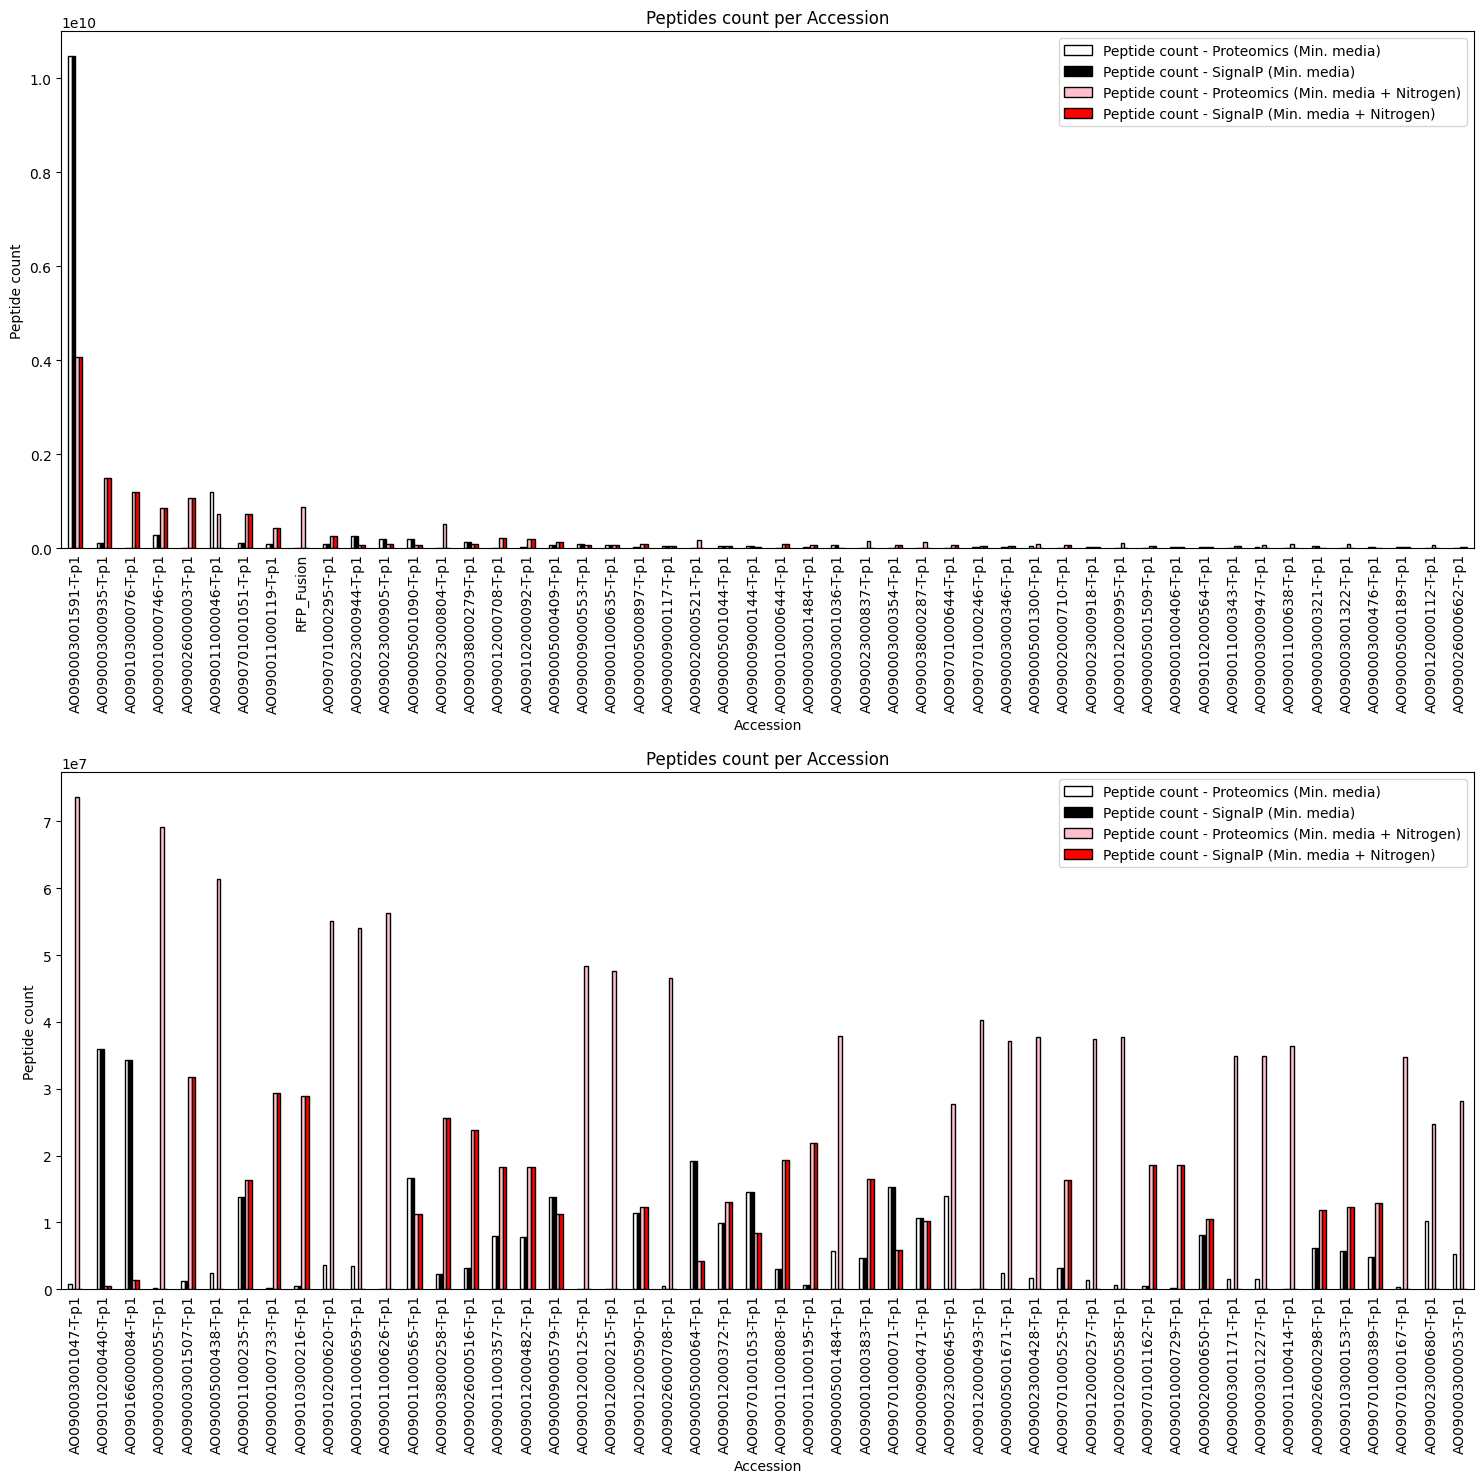

In [15]:
# If you want to plot the entire chunks, change figure size to "figsize=(10, n*5)" and enumaration to "enumerate(df_chunks)"

# Split the dataframe into chunks based on the number of subplots desired
chunk_size = 50  # Adjust this Accesssion value as needed
n = math.ceil(len(df_peptide_count_merged_total) / chunk_size)
df_chunks = [df_peptide_count_merged_total[i:i+chunk_size] for i in range(0, len(df_peptide_count_merged_all), chunk_size)]

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
all_bars = ['Peptide count - Proteomics (Min. media)', 'Peptide count - SignalP (Min. media)', 'Peptide count - Proteomics (Min. media + Nitrogen)', 'Peptide count - SignalP (Min. media + Nitrogen)']

# Plot each chunk in a separate subplot
for i, df_chunk in enumerate(df_chunks[:2]):
    ax = axes[i]
    df_chunk.plot(x='Accession', y=all_bars, kind='bar', color=['none', 'black', 'pink', 'red'], edgecolor='black', ax=ax)
    ax.set_xlabel('Accession')
    ax.set_ylabel('Peptide count')
    ax.set_title('Peptides count per Accession')
    ax.grid(visible=False)  # Remove the gridlines
    ax.tick_params(axis='x', which='both', length=0)  # Remove the x-axis tick labels and ticks

plt.rc('font', size=12)
plt.tight_layout()
plt.show()

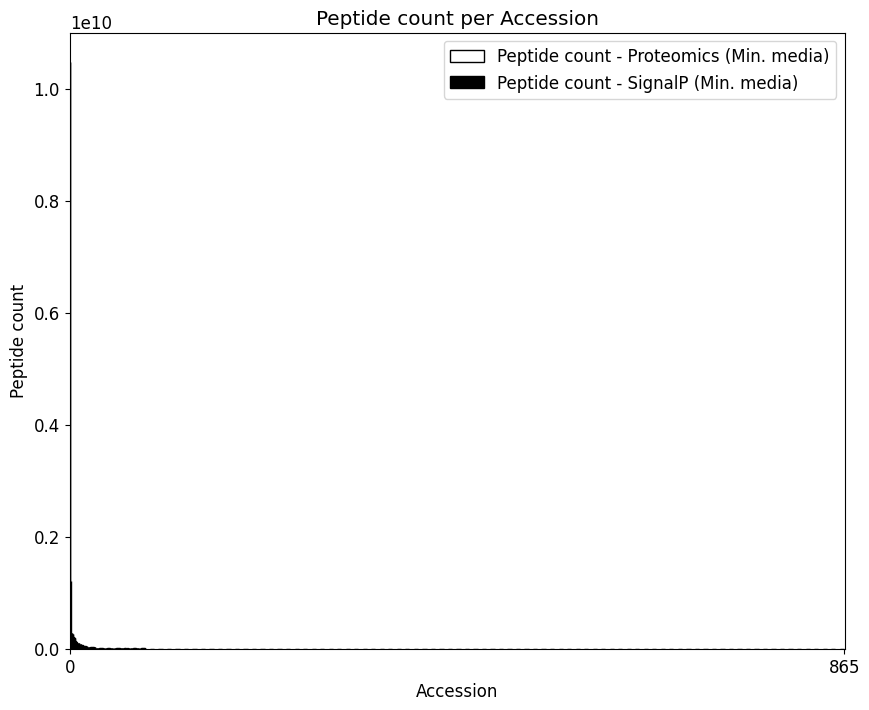

In [16]:
# Define the dataframes and extract the "Accession" and "# Peptides" columns
df_peptide_count_proteomics = df_merged_abundance_means[['Accession', 'mM mean abundances (Raw)']] 
df_peptide_count_signalP = df_merged_proteomics_signalPP[['Accession', 'mM mean abundances (Raw)']]

# Rename the "# Peptides" column to indicate which excel file it comes from
df_peptide_count_proteomics = df_peptide_count_proteomics.rename(columns={'mM mean abundances (Raw)': 'Peptide count - Proteomics (Min. media)'})
df_peptide_count_signalP = df_peptide_count_signalP.rename(columns={'mM mean abundances (Raw)': 'Peptide count - SignalP (Min. media)'})

# Merge the dataframes on the "Accession" column
df_peptide_count_merged_mM = pd.merge(df_peptide_count_proteomics, df_peptide_count_signalP, on='Accession', how='outer')

# Fill any NaN values with 0
df_peptide_count_merged_mM = df_peptide_count_merged_mM.fillna(0)

# Sort the dataframe by "# Peptides" in descending order
df_peptide_count_merged_mM = df_peptide_count_merged_mM.sort_values(by=['Peptide count - Proteomics (Min. media)', 'Peptide count - SignalP (Min. media)'], ascending=False)

# Generate the bar plot
df_peptide_count_merged_mM.plot(x='Accession', y=['Peptide count - Proteomics (Min. media)', 'Peptide count - SignalP (Min. media)'], kind='bar', title='Peptide count per Accession', color=['none', 'black'], edgecolor='black')

ax = plt.gca()
ax.set_xticks([0, df_peptide_count_merged_mM.index.get_loc(df_peptide_count_merged_mM.index[-1])])
ax.set_xticklabels([0, df_peptide_count_merged_mM.index.get_loc(df_peptide_count_merged_mM.index[-1])], rotation=0)
ax.figure.set_size_inches(10, 8)

plt.rc('font', size=12)
plt.xlabel('Accession')
plt.ylabel('Peptide count')
plt.show()

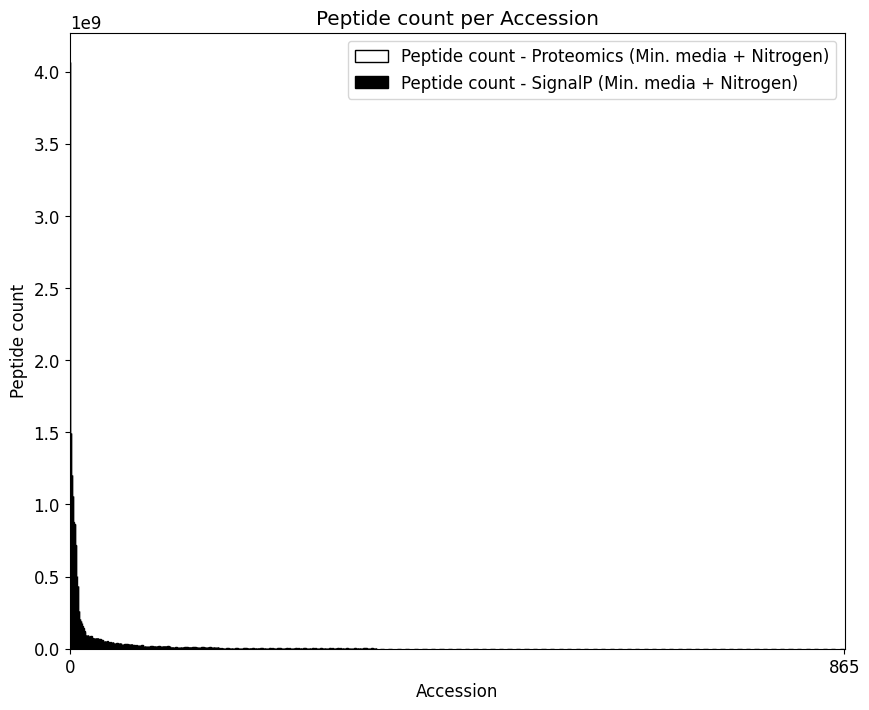

In [17]:
# Define the dataframes and extract the "Accession" and "# Peptides" columns
df_peptide_count_proteomics = df_merged_abundance_means[['Accession', 'mMN mean abundances (Raw)']] 
df_peptide_count_signalP = df_merged_proteomics_signalPP[['Accession', 'mMN mean abundances (Raw)']]

# Rename the "# Peptides" column to indicate which excel file it comes from
df_peptide_count_proteomics = df_peptide_count_proteomics.rename(columns={'mMN mean abundances (Raw)': 'Peptide count - Proteomics (Min. media + Nitrogen)'})
df_peptide_count_signalP = df_peptide_count_signalP.rename(columns={'mMN mean abundances (Raw)': 'Peptide count - SignalP (Min. media + Nitrogen)'})

# Merge the dataframes on the "Accession" column
df_peptide_count_merged_mMN = pd.merge(df_peptide_count_proteomics, df_peptide_count_signalP, on='Accession', how='outer')

# Fill any NaN values with 0
df_peptide_count_merged_mMN = df_peptide_count_merged_mMN.fillna(0)

# Sort the dataframe by "# Peptides" in descending order
df_peptide_count_merged_mMN = df_peptide_count_merged_mMN.sort_values(by=['Peptide count - Proteomics (Min. media + Nitrogen)', 'Peptide count - SignalP (Min. media + Nitrogen)'], ascending=False)

# Generate the bar plot
df_peptide_count_merged_mMN.plot(x='Accession', y=['Peptide count - Proteomics (Min. media + Nitrogen)', 'Peptide count - SignalP (Min. media + Nitrogen)'], kind='bar', title='Peptide count per Accession', color=['none', 'black'], edgecolor='black')

ax = plt.gca()
ax.set_xticks([0, df_peptide_count_merged_mMN.index.get_loc(df_peptide_count_merged_mMN.index[-1])])
ax.set_xticklabels([0, df_peptide_count_merged_mMN.index.get_loc(df_peptide_count_merged_mMN.index[-1])], rotation=0)
ax.figure.set_size_inches(10, 8)

plt.rc('font', size=12)
plt.xlabel('Accession')
plt.ylabel('Peptide count')
plt.show()

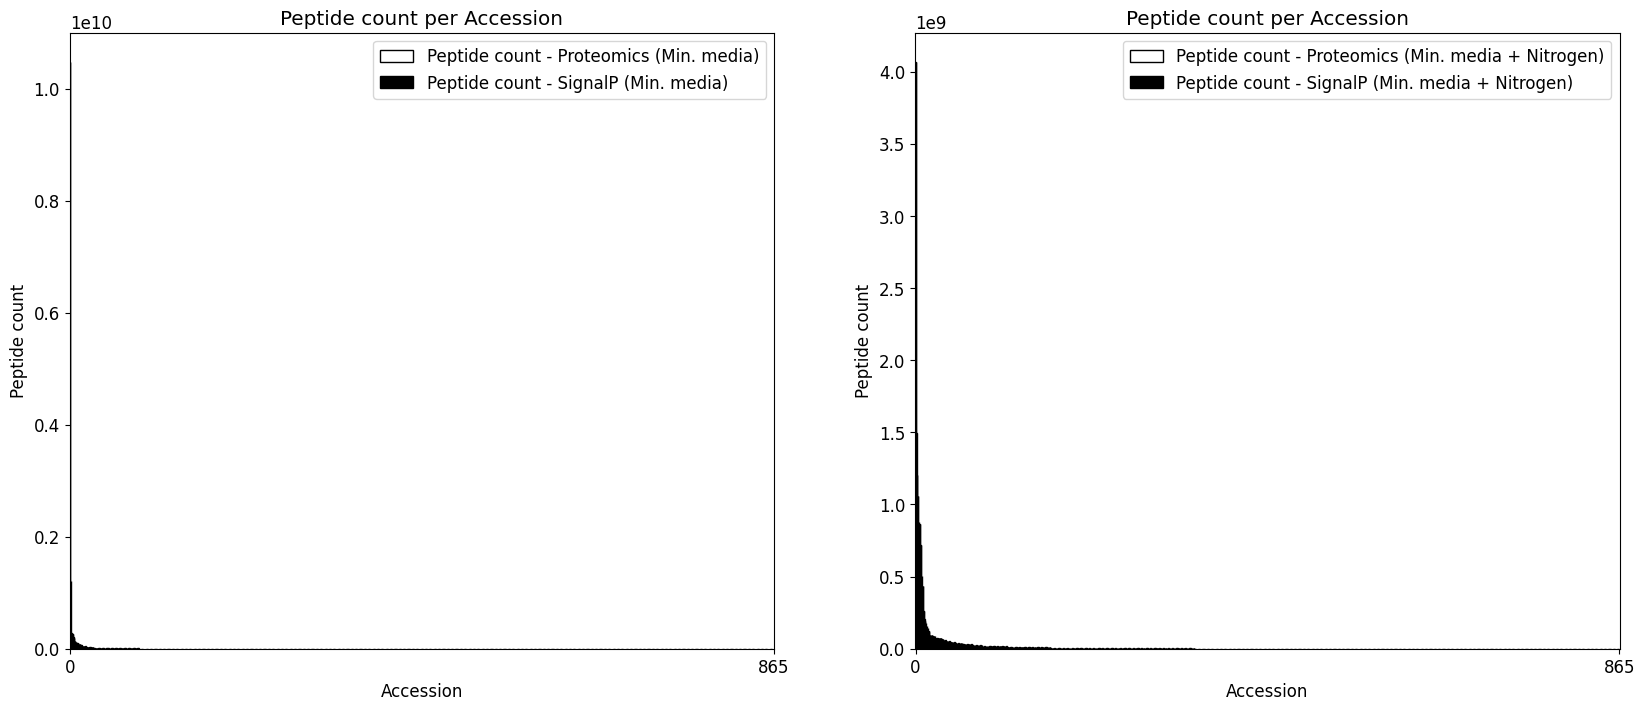

In [18]:
# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first plot in the left subplot
df_peptide_count_merged_mM.plot(x='Accession', y=['Peptide count - Proteomics (Min. media)', 'Peptide count - SignalP (Min. media)'], kind='bar', title='Peptide count per Accession', color=['none', 'black'], edgecolor=['black', 'black'], hatch='', ax=axs[0])
axs[0].set_xlabel('Accession')
axs[0].set_ylabel('Peptide count')
axs[0].set_xticks([0, df_peptide_count_merged_mM.index.get_loc(df_peptide_count_merged_mM.index[-1])])
axs[0].set_xticklabels([0, df_peptide_count_merged_mM.index.get_loc(df_peptide_count_merged_mM.index[-1])], rotation=0)


# Plot the second plot in the right subplot
df_peptide_count_merged_mMN.plot(x='Accession', y=['Peptide count - Proteomics (Min. media + Nitrogen)', 'Peptide count - SignalP (Min. media + Nitrogen)'], kind='bar', title='Peptide count per Accession', color=['none', 'black'], edgecolor='black', ax=axs[1])
axs[1].set_xlabel('Accession')
axs[1].set_ylabel('Peptide count')
axs[1].set_xticks([0, df_peptide_count_merged_mMN.index.get_loc(df_peptide_count_merged_mMN.index[-1])])
axs[1].set_xticklabels([0, df_peptide_count_merged_mMN.index.get_loc(df_peptide_count_merged_mMN.index[-1])], rotation=0)

plt.rc('font', size=12)
plt.show()

#====================== ALTERNATIVE ======================#
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

#df_peptide_count_merged_mM.plot(x='Accession', y=['Peptide count - Proteomics (Min. media)', 'Peptide count - SignalP (Min. media)'], kind='bar', title='Peptide count per Accession', color=['none', 'black'], edgecolor=['black', 'black'], hatch='',ax=ax1)
#ax1.set_xlabel('Accession')
#ax1.set_ylabel('Peptide count')
#ax1.set_xticks([])

#df_peptide_count_merged_mMN.plot(x='Accession', y=['Peptide count - Proteomics (Min. media + Nitrogen)', 'Peptide count - SignalP (Min. media + Nitrogen)'], kind='bar', title='Peptide count per Accession', color=['none', 'black'], edgecolor=['black', 'black'], hatch='',ax=ax2)
#ax2.set_xlabel('Accession')
#ax2.set_ylabel('Peptide count')
#ax2.set_xticks([])

#plt.show()
#========================================================#

### Subplots - Minimum media

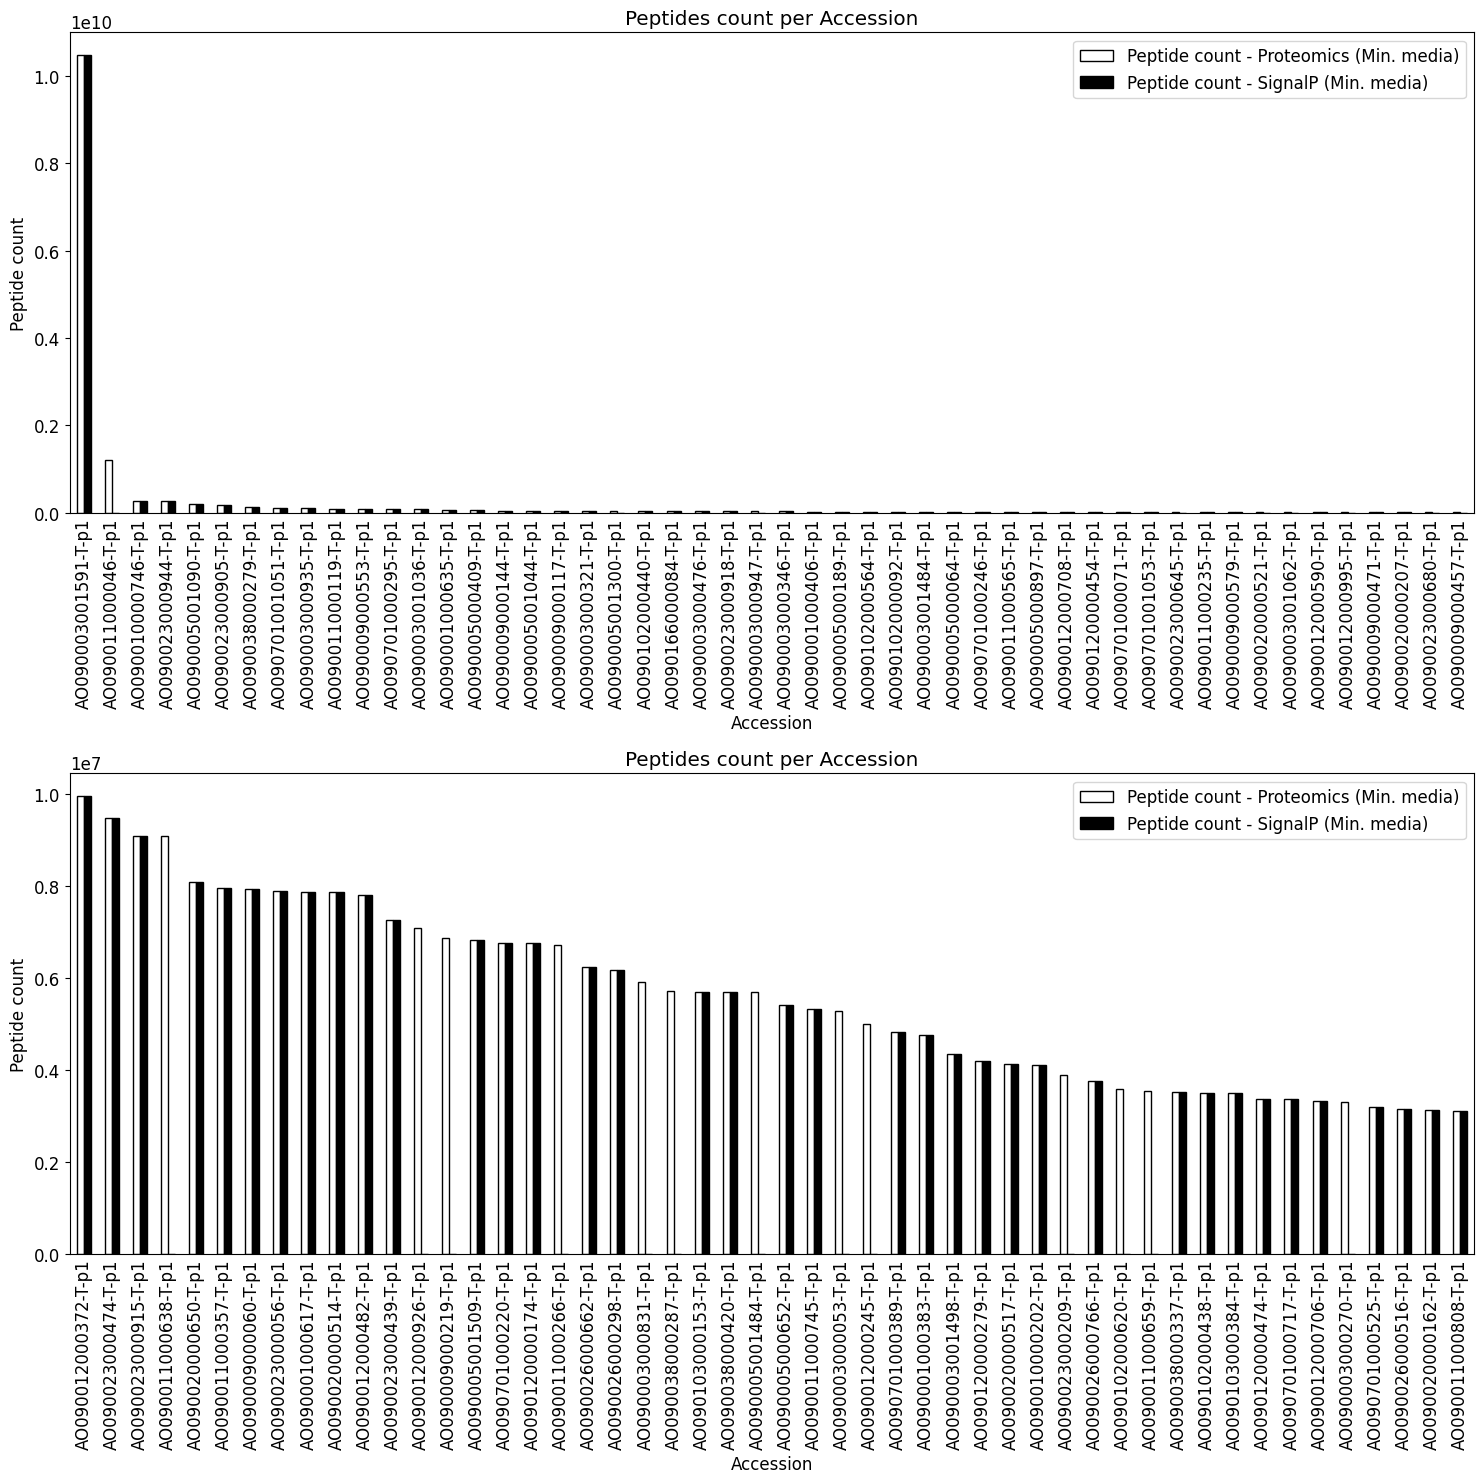

In [19]:
# If you want to plot the entire chunks, change figure size to "figsize=(10, n*5)" and enumaration to "enumerate(df_chunks)"

# Split the dataframe into chunks based on the number of subplots desired
chunk_size = 50  # Adjust this Accesssion value as needed
n = math.ceil(len(df_peptide_count_merged_mM) / chunk_size)
df_chunks = [df_peptide_count_merged_mM[i:i+chunk_size] for i in range(0, len(df_peptide_count_merged_mM), chunk_size)]

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Plot each chunk in a separate subplot
for i, df_chunk in enumerate(df_chunks[:2]):
    ax = axes[i]
    df_chunk.plot(x='Accession', y=['Peptide count - Proteomics (Min. media)', 'Peptide count - SignalP (Min. media)'], kind='bar', color=['none', 'black'], edgecolor='black', ax=ax)
    ax.set_xlabel('Accession')
    ax.set_ylabel('Peptide count')
    ax.set_title('Peptides count per Accession')
    ax.grid(visible=False)  # Remove the gridlines
    ax.tick_params(axis='x', which='both', length=0)  # Remove the x-axis tick labels and ticks

plt.tight_layout()
plt.rc('font', size=14)
plt.show()

### Subplot - Minimum media + Nitrogen

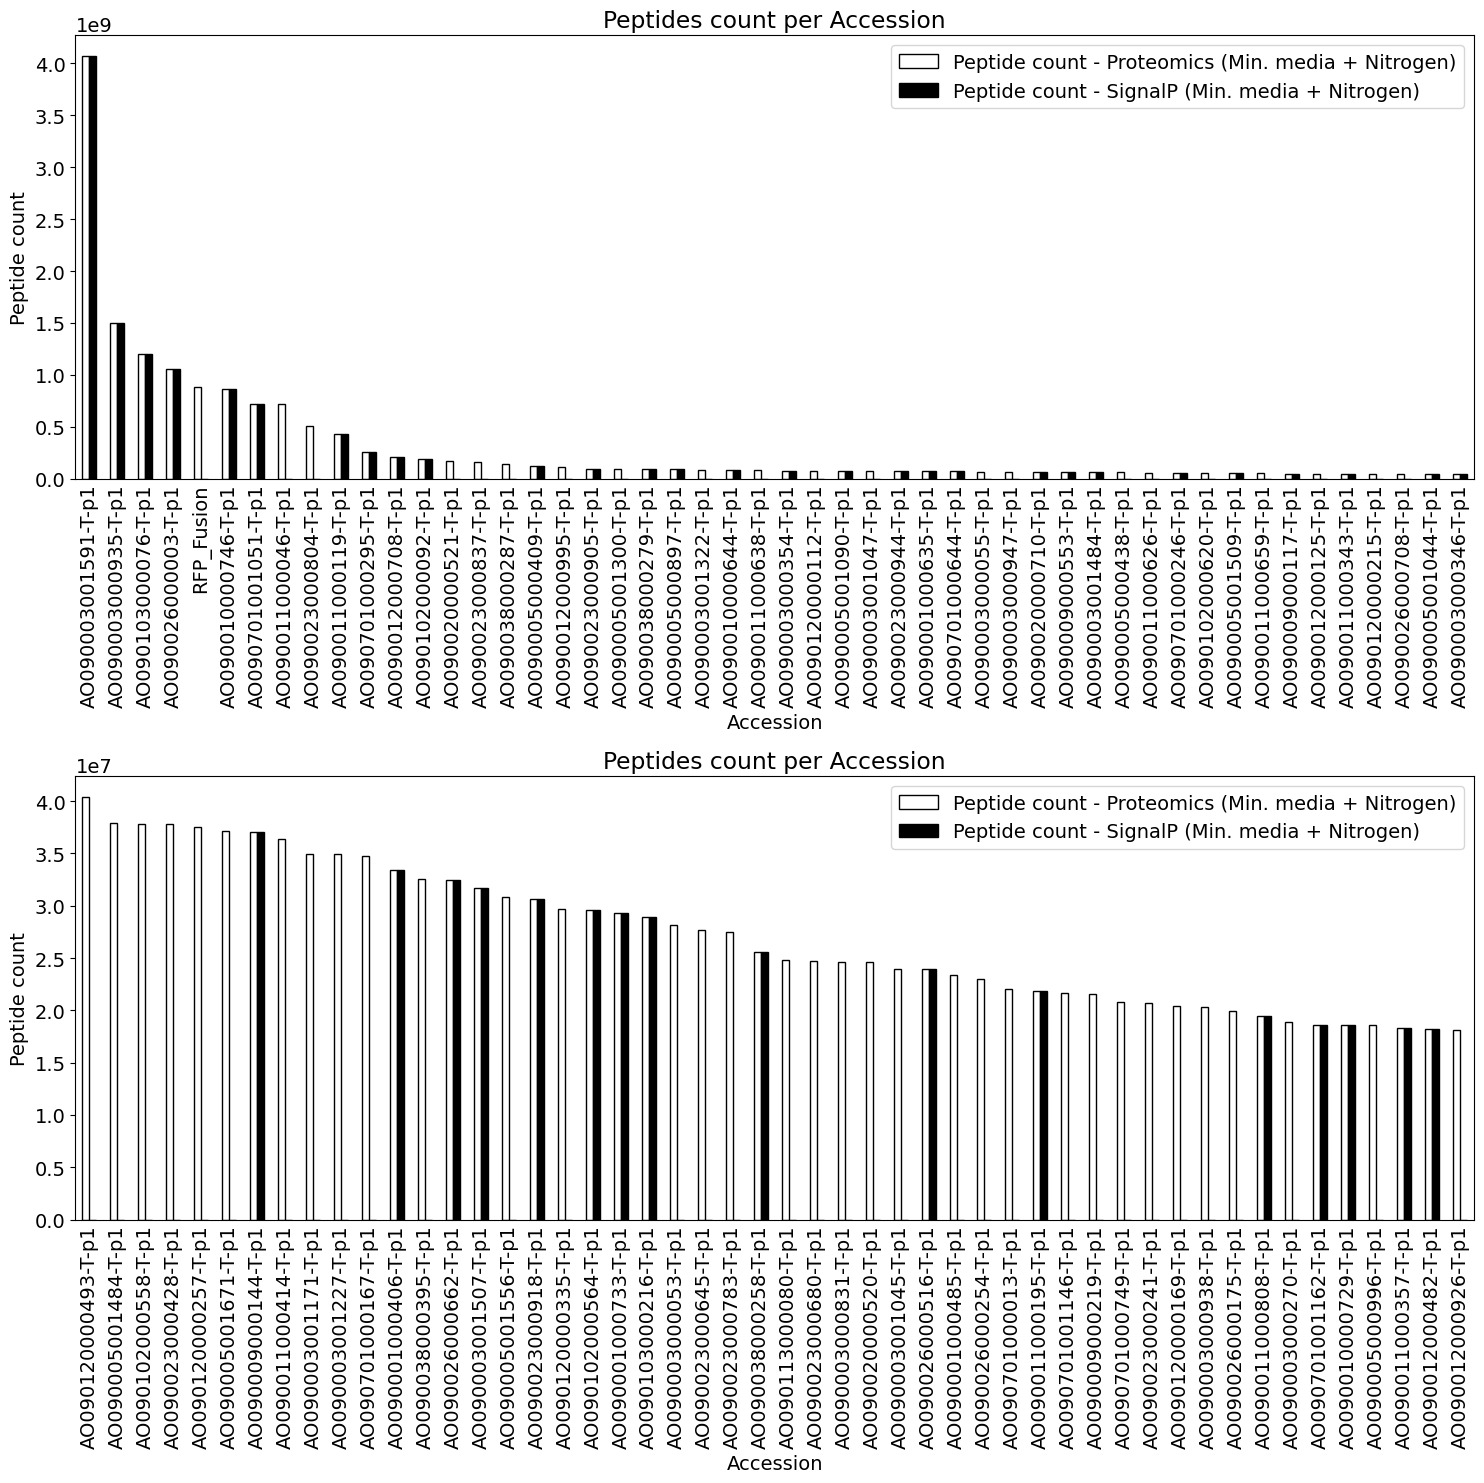

In [20]:
# If you want to plot the entire chunks, change figure size to "figsize=(10, n*5)" and enumaration to "enumerate(df_chunks)"

# Split the dataframe into chunks based on the number of subplots desired
chunk_size = 50  # Adjust this Accesssion value as needed
n = math.ceil(len(df_peptide_count_merged_mMN) / chunk_size)
df_chunks = [df_peptide_count_merged_mMN[i:i+chunk_size] for i in range(0, len(df_peptide_count_merged_mMN), chunk_size)]

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Plot each chunk in a separate subplot
for i, df_chunk in enumerate(df_chunks[:2]):
    ax = axes[i]
    df_chunk.plot(x='Accession', y=['Peptide count - Proteomics (Min. media + Nitrogen)', 'Peptide count - SignalP (Min. media + Nitrogen)'], kind='bar', color=['none', 'black'], edgecolor='black', ax=ax)
    ax.set_xlabel('Accession')
    ax.set_ylabel('Peptide count')
    ax.set_title('Peptides count per Accession')
    ax.grid(visible=False)  # Remove the gridlines
    ax.tick_params(axis='x', which='both', length=0)  # Remove the x-axis tick labels and ticks

plt.rc('font', size=12)
plt.tight_layout()
plt.show()

# SignalP predictions 

### Proteomics vs SignalP

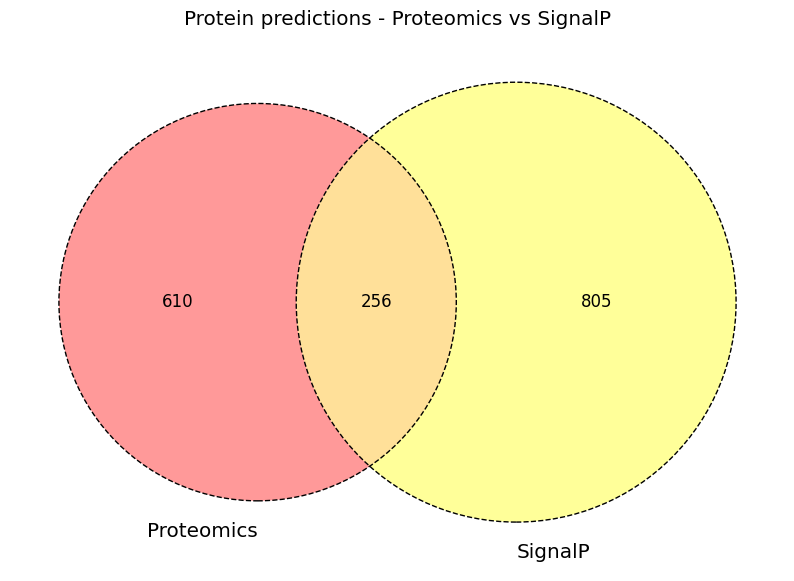

In [21]:
#  Create the subsets
df_proteomics_acc = set(df_proteomics['Accession'])
df_signalPP_acc = set(df_signalPP['Accession'])

# Create the Venn diagram
subsets = [df_proteomics_acc, df_signalPP_acc]
v = venn2(subsets, set_labels=('Proteomics', 'SignalP'), set_colors=('red', 'yellow'))
c = venn2_circles(subsets, linestyle='dashed', linewidth= 1.0)
plt.title("Protein predictions - Proteomics vs SignalP")
plt.gcf().set_size_inches(10, 8)
plt.rc('font', size=16)
plt.show()